# Tutorial for building a LSTM (Univariate Time Series Forecasting)
1. Link 1 (univariate, multivariate, and multi-step): https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
2. Link 2 (Univariate one-step - This tutorial): https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


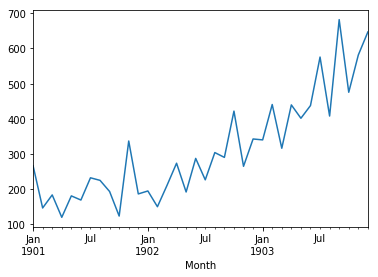

In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('Data/LSTM_data/sales_shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# Summarize first rows
print(series.head())

# Line plot
series.plot()
pyplot.show()


RMSE: 142.676


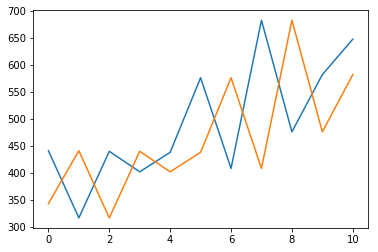

In [6]:
# Split the data into training and testing set
X = series.values
train, test = X[0:24], X[25:36]

# A rolling forecast sceneario (Walk-forward model validation)
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation (real value obtained)
    history.append(test[i])

# Report performance
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE: %0.3f' % rmse)
# Line plot of observed(real) vs. predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()


# LSTM Data Preparation
 Now that we have a baseline performance of the dataset, we can start developing an LSTM model for the data
 Before we can fit an LSTM model to the dataset, we need to transform the data.

 This section is broken down into three steps:
 1. Transform the time series into a supervised learning problem
 2. Transform the time series data so that it is STATIONARY
 3. Transform the observations (real values observed) to have a specific scale

# 1. ----- Transform Time-Series to Supervised Learning -----
The LSTM model in Keras assumes that the data is divided into input(X) and output(Y)

For a time-series problem, we can achieve this by using the observation from the last time-step (t-1) as the input and the observation at the current time-step (t) as the output.

We can achieve this by using the shift() function in Pandas that will push all values in a series down by a specified number of places. We require a shift of 1 place, which will become the input variables. The original time series (without the shift) will be the output variables.

Then, we can concatenate these two series to create a Dataframe ready for supervised learning.The shifted series will have a new position at the top with NaN. This NaN will be replaced with a zero. The LSTM model will have to learn that ZERO as "the start of the series" or "I have not data here".


In [2]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

# Helper function to perform shifting operation.
# Descriptiion: the function takes a NumPy array of the raw time series data and performs tha lag operation
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data) # creates the dataframe
    columns = [df.shift(i) for i in range (1,lag+1)] # performs shifting operation in a loop
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0,inplace=True)
    return df

 
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('Data/LSTM_data/sales_shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())


       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


# 2. ----- Transform Time-Series to STATIONARY -----
The shampoo sales dataset is not stationary. This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillfull forecasts. The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate comparable error score.

A standard way of removing a trend is by differencing the data. That is, the observation from the previous time step (t-1) is substracted from the current observation (t). This removes the trend and we are left with a difference series, or only the changes from one time step to the next.

We can achieve this automatically using the diff() fucntion in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred due to flexibility.

In [3]:
from pandas import read_csv
from pandas import datetime
from pandas import Series

## --- Functions -----
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# create differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

## --- Execution -----
series = read_csv('Data/LSTM_data/sales_shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())

# transform to stationary
differenced = difference(series,1)
print(differenced.head())

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)

inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


# 3. ----- Transform Time-Series to Scale -----
Similar to toher neural networks, LSTMs expect data to be within the scale of the activation fucntion used in the network.

The default af (activation function) for LSTMs is the hyperbolic tangent (tanh) - ouputs values between -1 and 1.

*Important* - To make the experiment fair, the scaling coefficients (min and max) values must be be calculated on the *training* dataset and applied to scale the test dataset and any forecasts. This is done to avoid contaminating the expriment with knowledge from the test dataset, which can give the model a small edge.

We can transform the dataset to the range [-1,1] using the MinMaxScaler class. It requires data provided to be in a matrix form with rows and columns. Therefore, we must reshape our NumPy arrays before transforming. 

In [4]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler

# --- Functions ----
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# --- Execution ----
series = read_csv('Data/LSTM_data/sales_shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())

# transform scale
X = series.values
X = X.reshape(len(X), 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)         # matrix form
scaled_series = Series(scaled_X[:, 0]) # Series form
print(scaled_series.head())


# invert transform
inverted_X = scaler.inverse_transform(scaled_X) # matrix form
inverted_series = Series(inverted_X[:, 0])      # Series form
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


## LSTM Model Development
The LSTM is a type of RNN. One of the main benefits of this type of netwrok is that:

*it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.*

In Keras, this is referred to as stateful, and onvolves setting the "stateful" argument to "TRUE" when defining an LSTM layer.

By default, an LSTM in Keras maintains state between within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. 

State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the *reset_states()* function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time_steps, features].

1. Samples: these are independent observations from the domain, typically the rows of the data.
2. Time steps: these are separate time steps of a given variable for a given observation.
3. Features: these are separate measures observed at the time of observation.

For this problem we will frame it as: each time step in the original sequence is one separate sample, with one timestep and one feature.

In [10]:
# Since the training dataset is defined as X inputs and y outputs
# It must be reshaped into Samples/TimeSteps/Features

# --- fit_lstm Function ----
# Description: this function trains and returns an LSTM model.
# Arguments: training dataset - supervised learning format,
#            batch size, number of epochs, number of neurons
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]),stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model


### For testing in this tutorial, let's use:
1. Batch size = 1
2. Epochs = 3000
3. Neurons = 4

Also consider trying 1500 epochs and 1 neuron to see if the performance gets better.

## LSTM Forecast
We will look at how we can use a fit LSTM model to make a one-step forecast.

There are some options(flexibility) to fit the model once it's trained.
1. We can decide to fit the model *ONCE* on all of the training data, and then predict each new time step one at a time from the test data (FIXED APPROACH).
2. Or, we can decide to re-fit the model (update the model) at each time step of the test data as new observations from the test data are made available (DYNAMIC APPROACH)

Here, we will go with the fixed approach for its simplicity, although, we would expect the dynamic approach to result in better model skill.

To make a forecast, we can call the *predict()* function on the model. This requires a 3D NumPy array input as an argument. In this case, it will be an array of one value, the observation at the previous time step.

The *predict()* function returns an array of predictons, one for each input row provided. Because we are providing a single input, the ouput will be a 2D NumPy array with one value.

We can capture this behavior in a function named *forecast()*: Given a fit model, a batch-size used when fitting the model (e.g. 1), and a row from the test data, the function will separate out the input data from the test row, reshape it, and return the prediction as a single floating point value.



In [11]:
def forecast(model, batch_size, row):
    X = row[0:-1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

During training, the internal state is reset after each epoch. While forecasting, we will not want to reset the internal state between forecasts. In fact, we would like the model to build up state as we forecast each time step in the test dataset.

This raises the question as to what would be a good initial state for the network prior to forecasting the test dataset.

In this tutorial, we will seed the state by making a prediction on all samples in the training dataset. In theory, the internal state should be set up ready to forecast the next time step.

We now have all of the pieces to fit an LSTM Network model for the Shampoo Sales dataset and evaluate its performance.

In the next section, we will put all of these pieces together.

# Complete LSTM Example
In this section, we will fit an LSTM to the Shampoo Sales dataset and evaluate the model.

All Steps:
1. Load the dataset from CSV file.
2. Transform the dataset to make it suitable for the LSTM model, including:
    1. Transforming the data to a supervised learning problem.
    2. Transforming the data to be stationary.
    3. Transforming the data so that it has the scale -1 to 1.
3. Fitting a stateful LSTM network model to the training data.
4. Evaluating the static LSTM model on the test data.
5. Report the performance of the forecasts.

Some things to note about the example:

1. The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.
2. The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
3. The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.
4. Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.

Month=1, Predicted=339.700000, Expected=339.700000
Month=2, Predicted=440.400000, Expected=440.400000
Month=3, Predicted=315.900000, Expected=315.900000
Month=4, Predicted=439.300000, Expected=439.300000
Month=5, Predicted=401.300000, Expected=401.300000
Month=6, Predicted=437.400000, Expected=437.400000
Month=7, Predicted=575.500000, Expected=575.500000
Month=8, Predicted=407.600000, Expected=407.600000
Month=9, Predicted=682.000000, Expected=682.000000
Month=10, Predicted=475.300000, Expected=475.300000
Month=11, Predicted=581.300000, Expected=581.300000
Month=12, Predicted=646.900000, Expected=646.900000
Test RMSE: 0.000


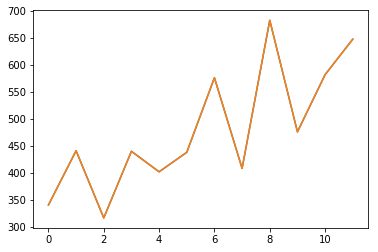

In [3]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# ---- Functions -----
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# ---- Execution ----
# load dataset
series = read_csv('Data/LSTM_data/sales_shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4) # training dataset, batch sized, epochs, neurons

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    #yhat = y # Test that all other fucntions(scaling, diff, etc.) are working - Prediction is exact
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

## Develop a Robust Result
A difficulty with neural networks is that they give different results with different starting conditions.

One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.

We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

This is often called multiple repeats or multiple restarts.

We can wrap the model fitting and walk-forward validation in a loop of fixed number of repeats. Each iteration the RMSE of the run can be recorded. We can then summarize the distribution of RMSE scores.

We will use 30 repeats as that is sufficient to provide a good distribution of RMSE scores.

Using TensorFlow backend.
/home/juan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1) Test RMSE: 196.204
2) Test RMSE: 96.044
3) Test RMSE: 95.583
4) Test RMSE: 118.901
5) Test RMSE: 103.137
6) Test RMSE: 123.862
7) Test RMSE: 104.639
8) Test RMSE: 95.873
9) Test RMSE: 91.595
10) Test RMSE: 103.620
11) Test RMSE: 89.392
12) Test RMSE: 99.281
13) Test RMSE: 116.372
14) Test RMSE: 85.867
15) Test RMSE: 98.433
16) Test RMSE: 232.819
17) Test RMSE: 182.058
18) Test RMSE: 327.716
19) Test RMSE: 102.804
20) Test RMSE: 131.752
21) Test RMSE: 128.263
22) Test RMSE: 103.047
23) Test RMSE: 117.910
24) Test RMSE: 98.495
25) Test RMSE: 107.122
26) Test RMSE: 91.033
27) Test RMSE: 183.618
28) Test RMSE: 99.043
29) Test RMSE: 109.532
30) Test RMSE: 106.743
             rmse
count   30.000000
mean   124.691971
std     51.954181
min     85.867330
25%     98.448298
50%    104.129444
75%    122.622066
max    327.715585


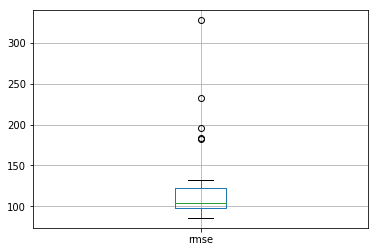

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# ---- Functions -----
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# ---- Execution ----
# load dataset
series = read_csv('Data/LSTM_data/sales_shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


# --- Repeat experiment ---
repeats = 30
error_scores = list()

for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4) # training dataset, batch sized, epochs, neurons

    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # yhat = y # Test that all other fucntions(scaling, diff, etc.) are working - Prediction is exact
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()